# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image
from skimage import color

# File import and Frame Grabber Function

In [2]:
def frame_grabber(file):
    video_file = file + '.avi'
    # Opens the Video file
    cap= cv2.VideoCapture(video_file)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        if (i < 10):
            cv2.imwrite(file + '-00'  + str(i)+'.png',frame)
        elif (10 <= i < 100) :
            cv2.imwrite(file + '-0' + str(i) + '.png', frame)
        else:
            cv2.imwrite(file + '-' + str(i) + '.png', frame)
        i+=1
 
    cap.release()
    cv2.destroyAllWindows()

# File Read Function

In [3]:
def read_files(file):
    #Reading the images from the directory
    filename = glob.glob(file + '*png')

    file_name = {}

    for i in range(len(filename)):
        file_name[i] = np.double(Image.open(str(filename[i])).convert('L'))
        
    return(file_name)

# Image Differencing Function

In [4]:
#Function for image differencing by using closing and dilate to remove or cleanup tiny regions

def image_differencing(Im,threshold):
    diffIm = []

    for i in range(len(Im)-1):
        m = abs(np.subtract(Im[i+1],Im[i])) >= threshold
        m = np.uint8(m*1)
    
        kernel = np.ones((3,3),np.uint8)

        n = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)
        cleaned = cv2.dilate(n, kernel, iterations = 1)
    
        diffIm.append(cleaned)
        
    return(diffIm)

# Background Subtraction Function

In [5]:
def background_subtraction(Im, background, threshold):
    bgs = {}
    for i in range(len(Im)):
        bgs[i] = abs(Im[i] - background) > threshold
        
    return(bgs)

# MHI function

In [6]:
def MHI(image, delta):
    mhi = np.zeros((np.shape(image[0])[0],np.shape(image[0])[1]), np.uint8)
    
    row, column = np.shape(image[0])
    
    for timestamp in range(0,len(image)):
        frame = image[timestamp]

        for y in range(row):
            for x in range(column):
                if(frame[y,x] == 1):
                    mhi[y,x] = timestamp
                else:
                    if(mhi[y,x] < timestamp - delta):
                        mhi[y,x] = 0
                        

    fig= plt.figure(figsize=(5,5))
    fig.suptitle('The final MHI is', fontsize = 20)
    plt.imshow(mhi)
    plt.gray()
    plt.axis('off')
    plt.show()

    return(np.asarray(mhi))

# MEI function

In [7]:
#Function for calculating Binary Motion Energy Image
def MEI(Im):
    mei = np.zeros((np.shape(Im[0])[0],np.shape(Im[0])[1]), np.uint8)
    
    #The MEI/MHI duration should include all image diff results in the sequence into the final template.
    #So, frames to be considered i.e., delta = 22
    
    for i in range(len(Im)):
        mei = mei + Im[i]
    
        mei = mei>0
        
    fig= plt.figure(figsize=(5,5))
    fig.suptitle('The final MEI is', fontsize = 20)  
    plt.imshow(mei)
    plt.axis('off')
    plt.show()

    return(np.asarray(mei))

# Normalizing function

In [8]:
def normalize(mhi,mei):
    #Normalize MHI and MEI,

    mhi_n = np.fmax(0,(mhi - 1.0)/(np.max(mhi)-1))

    print('Maximum value in MHI: ', np.max(mhi_n))
    print('Minimum value in MHI: ', np.min(mhi_n))

    mei_n = mei*1.0

    print('Maximum value in MEI: ', np.max(mei_n))
    print('Minimum value in MEI: ', np.min(mei_n))
    
    return(mhi_n,mei_n)

# Similitude Moments Function

In [9]:
#Function for calculating similitude moments
def similitude_moments(Im):
    
    y, x = np.mgrid[range(Im.shape[0]),range(Im.shape[1])]
    
    similitude_moments = []
    
    x_bar = np.sum(x*Im)/np.sum(Im)
    y_bar = np.sum(y*Im)/np.sum(Im)
    
    #Since 2 <= (i+j) <=3, the similitude moments
    for i in range(4):
        for j in range(4):
            if(2 <= (i+j) <= 3):
                s = np.sum(((x-x_bar)**i)*((y-y_bar)**j)*Im) / (np.sum(Im))**(((i+j)/2)+1)
                similitude_moments.append(s)

    return(similitude_moments)

# Walk

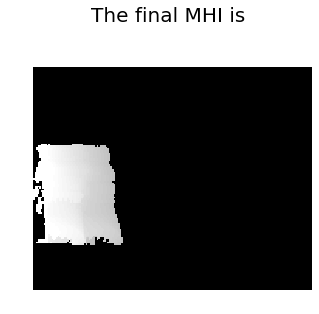

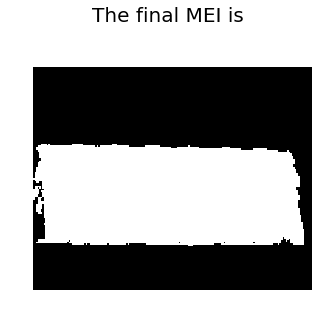

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.11949343141404235, 0.0001964620596115351, 0.012475393868457077, 0.0005810877700309301, 0.0738005157733836, 0.0014219792559902564, 0.0023446135637322494]
Similitude moments for normalized MEI is:
 [0.031168866178197013, -1.657216192185728e-05, 0.005788817765182178, -0.00047316065535291655, 0.22203103762650894, 0.00027456735957631786, 0.002170344459932589]


In [10]:
frame_grabber('daria_walk')
daria_walk = read_files('daria_walk')
frame_grabber('bg_015')
daria_bg = read_files('bg_015')
daria_walk_bs = background_subtraction(daria_walk,daria_bg[0],40)
daria_walk_mhi = MHI(daria_walk_bs,20)
daria_walk_mei = MEI(daria_walk_bs)

daria_walk_mhi_n, daria_walk_mei_n = normalize(daria_walk_mhi, daria_walk_mei)
daria_walk_mhi_sm = similitude_moments(daria_walk_mhi_n)
daria_walk_mei_sm = similitude_moments(daria_walk_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_walk_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_walk_mei_sm)
daria_walk_sm = daria_walk_mhi_sm + daria_walk_mei_sm

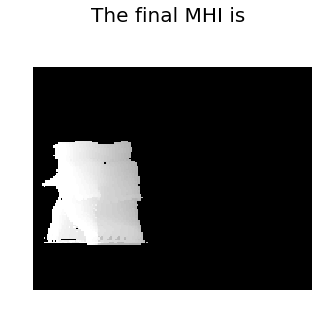

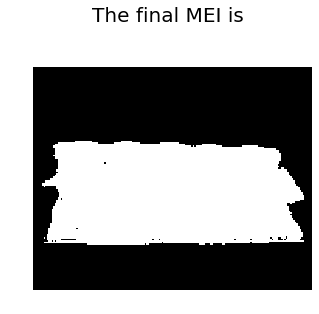

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.11184523699769428, -0.0028085349743688917, 0.0038675107561396906, -0.0006216219793539602, 0.07992115534382928, 0.0032161301062837116, 0.002490072047074581]
Similitude moments for normalized MEI is:
 [0.03451650831665496, -0.00025946538131803944, 0.004106781579133935, -0.0010725468519018017, 0.2012733158820561, 0.0023765162752088314, 0.0036376925749023624]


In [11]:
frame_grabber('denis_walk')
denis_walk = read_files('denis_walk')
frame_grabber('bg_026')
denis_bg = read_files('bg_026')
denis_walk_bs = background_subtraction(denis_walk,denis_bg[0],20)
denis_walk_mhi = MHI(denis_walk_bs,20)
denis_walk_mei = MEI(denis_walk_bs)

denis_walk_mhi_n, denis_walk_mei_n = normalize(denis_walk_mhi, denis_walk_mei)
denis_walk_mhi_sm = similitude_moments(denis_walk_mhi_n)
denis_walk_mei_sm = similitude_moments(denis_walk_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_walk_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_walk_mei_sm)
denis_walk_sm = denis_walk_mhi_sm + denis_walk_mei_sm

# Run

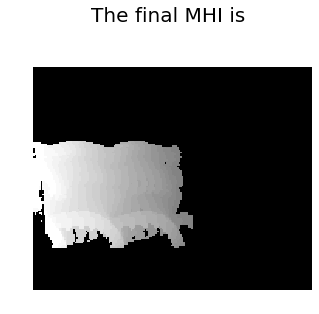

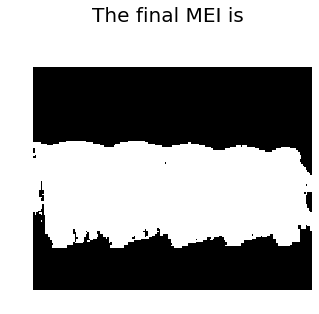

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.07436789113911924, 0.0009712281528967012, 0.008375788580181377, -5.083423910106752e-05, 0.15810119711508858, -0.00015641584073521425, 0.016122116940381615]
Similitude moments for normalized MEI is:
 [0.029736653331888737, 0.00016196044531061252, 0.005777532429429569, -0.0008730418819757181, 0.23628634927177092, -0.00034377866148745296, 0.003595047033446435]


In [12]:
frame_grabber('daria_run')
daria_run = read_files('daria_run')
daria_run_bs = background_subtraction(daria_run,daria_bg[0],40)
daria_run_mhi = MHI(daria_run_bs,20)
daria_run_mei = MEI(daria_run_bs)

daria_run_mhi_n, daria_run_mei_n = normalize(daria_run_mhi, daria_run_mei)
daria_run_mhi_sm = similitude_moments(daria_run_mhi_n)
daria_run_mei_sm = similitude_moments(daria_run_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_run_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_run_mei_sm)
daria_run_sm = daria_run_mhi_sm + daria_run_mei_sm

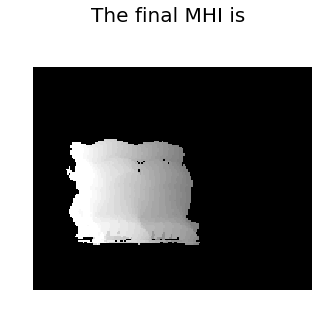

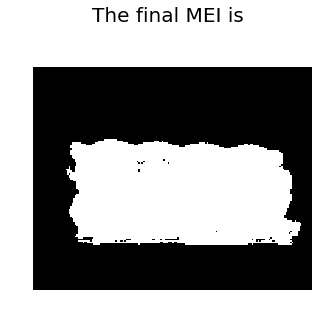

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.09270860096550859, -0.0012665501950772102, 0.011281835137176743, 0.0004095301525176906, 0.12165370140381494, 0.002444129002649898, 0.011502505042541243]
Similitude moments for normalized MEI is:
 [0.03824393905444247, -0.00015324165705594715, 0.0073129545152655325, -0.0004897780360002223, 0.18228441365937192, 0.0009470779421861413, 0.001617858204110581]


In [13]:
frame_grabber('denis_run')
denis_run = read_files('denis_run')
denis_run_bs = background_subtraction(denis_run,denis_bg[0],20)
denis_run_mhi = MHI(denis_run_bs,20)
denis_run_mei = MEI(denis_run_bs)

denis_run_mhi_n, denis_run_mei_n = normalize(denis_run_mhi, denis_run_mei)
denis_run_mhi_sm = similitude_moments(denis_run_mhi_n)
denis_run_mei_sm = similitude_moments(denis_run_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_run_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_run_mei_sm)
denis_run_sm = denis_run_mhi_sm + denis_run_mei_sm

# Skip

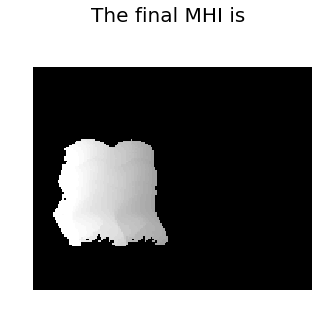

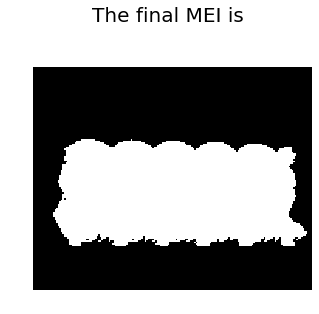

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.10232126052588199, -0.002032462416969366, 0.002629536811674643, 0.0016354307958519442, 0.09579748789855828, 0.004035929721225946, 0.0055462872640465065]
Similitude moments for normalized MEI is:
 [0.03516333770178971, -0.00011666359799830427, 0.002947947169251592, -0.00010125197693094212, 0.1993446832217005, 0.0016632283672621743, 0.00184742294967801]


In [14]:
frame_grabber('daria_skip')
daria_skip = read_files('daria_skip')
daria_skip_bs = background_subtraction(daria_skip,daria_bg[0],40)
daria_skip_mhi = MHI(daria_skip_bs,20)
daria_skip_mei = MEI(daria_skip_bs)

daria_skip_mhi_n, daria_skip_mei_n = normalize(daria_skip_mhi, daria_skip_mei)
daria_skip_mhi_sm = similitude_moments(daria_skip_mhi_n)
daria_skip_mei_sm = similitude_moments(daria_skip_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_skip_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_skip_mei_sm)
daria_skip_sm = daria_skip_mhi_sm + daria_skip_mei_sm

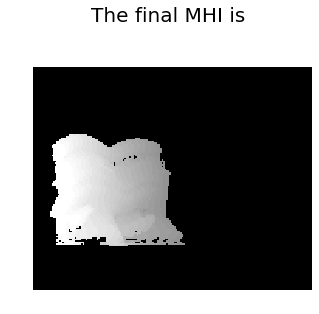

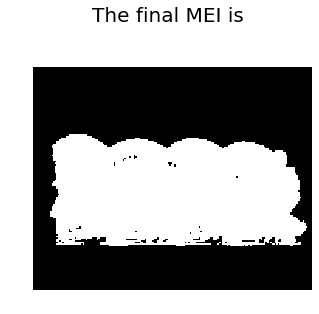

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.09663503321170919, -0.0013339126526206082, 0.012564285591945149, -0.00011720516665563942, 0.11435756272610363, 0.003420048579562918, 0.010150548037907388]
Similitude moments for normalized MEI is:
 [0.03542377529139881, -0.0001858527048395355, 0.007242724508055671, -0.0009459996244633846, 0.19955768374733043, 0.0012038795849591253, 0.0025819659008391523]


In [15]:
frame_grabber('denis_skip')
denis_skip = read_files('denis_skip')
denis_skip_bs = background_subtraction(denis_skip,denis_bg[0],20)
denis_skip_mhi = MHI(denis_skip_bs,20)
denis_skip_mei = MEI(denis_skip_bs)

denis_skip_mhi_n, denis_skip_mei_n = normalize(denis_skip_mhi, denis_skip_mei)
denis_skip_mhi_sm = similitude_moments(denis_skip_mhi_n)
denis_skip_mei_sm = similitude_moments(denis_skip_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_skip_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_skip_mei_sm)
denis_skip_sm = denis_skip_mhi_sm + denis_skip_mei_sm

# Bend

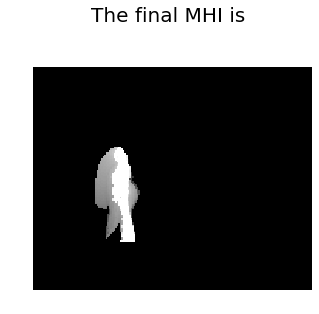

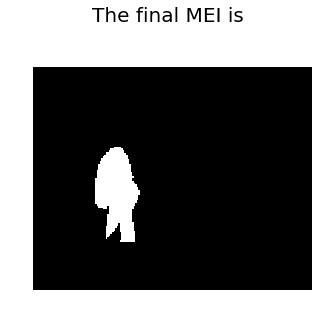

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.27496677800165403, 0.029706975663818497, 0.03259509389946543, 0.01186044829692258, 0.04423442138824988, 0.0014854847917919493, -0.0036237156489745377]
Similitude moments for normalized MEI is:
 [0.19511822186712946, 0.012134814615440076, 0.020491456301066573, 0.005978653154514075, 0.03910601502350061, 0.0008792192316571996, -0.0009621500745408682]


In [16]:
frame_grabber('daria_bend')
daria_bend = read_files('daria_bend')
daria_bend_bs = background_subtraction(daria_bend,daria_bg[0],40)
daria_bend_mhi = MHI(daria_bend_bs,83)
daria_bend_mei = MEI(daria_bend_bs)

daria_bend_mhi_n, daria_bend_mei_n = normalize(daria_bend_mhi, daria_bend_mei)
daria_bend_mhi_sm = similitude_moments(daria_bend_mhi_n)
daria_bend_mei_sm = similitude_moments(daria_bend_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_bend_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_bend_mei_sm)
daria_bend_sm = daria_bend_mhi_sm + daria_bend_mei_sm

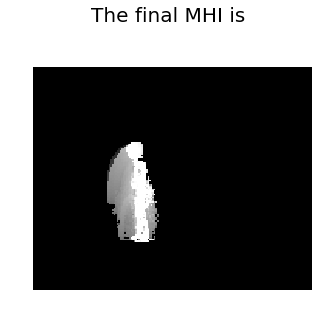

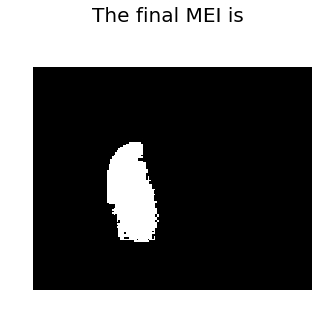

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.24828789090894074, -0.006144986304352056, 0.02669667739896439, 0.0032165346820027716, 0.04642267081082117, 0.0020410683562868672, -0.0027444497092695345]
Similitude moments for normalized MEI is:
 [0.1809624038036457, -0.005959832813020354, 0.023004913870119797, 0.002627425918505052, 0.04009523000812091, 0.001854041769710785, 5.4776117856320174e-05]


In [17]:
frame_grabber('denis_bend')
denis_bend = read_files('denis_bend')
denis_bend_bs = background_subtraction(denis_bend,denis_bg[0],30)
denis_bend_mhi = MHI(denis_bend_bs,83)
denis_bend_mei = MEI(denis_bend_bs)

denis_bend_mhi_n, denis_bend_mei_n = normalize(denis_bend_mhi, denis_bend_mei)
denis_bend_mhi_sm = similitude_moments(denis_bend_mhi_n)
denis_bend_mei_sm = similitude_moments(denis_bend_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_bend_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_bend_mei_sm)
denis_bend_sm = denis_bend_mhi_sm + denis_bend_mei_sm

# Jack

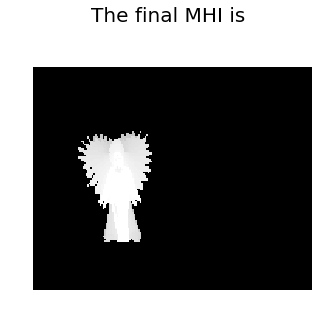

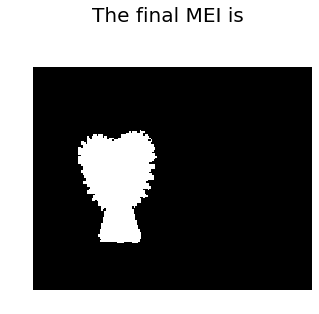

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.17850392728846534, 0.03196231320361088, 0.011289122645897536, 0.0043095537574922484, 0.053330066378340535, -0.009061242640154682, -0.0026786882887052]
Similitude moments for normalized MEI is:
 [0.1489705317342264, 0.023766293372647, 0.002591878350007225, 0.002521374680598223, 0.05516417336313951, -0.008074331784658127, -0.0012346949343812203]


In [18]:
frame_grabber('daria_jack')
daria_jack = read_files('daria_jack')
daria_jack_bs = background_subtraction(daria_jack,daria_bg[0],40)
daria_jack_mhi = MHI(daria_jack_bs,20)
daria_jack_mei = MEI(daria_jack_bs)

daria_jack_mhi_n, daria_jack_mei_n = normalize(daria_jack_mhi, daria_jack_mei)
daria_jack_mhi_sm = similitude_moments(daria_jack_mhi_n)
daria_jack_mei_sm = similitude_moments(daria_jack_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_jack_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_jack_mei_sm)
daria_jack_sm = daria_jack_mhi_sm + daria_jack_mei_sm

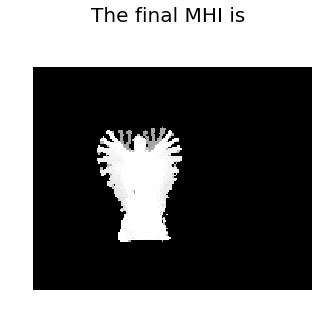

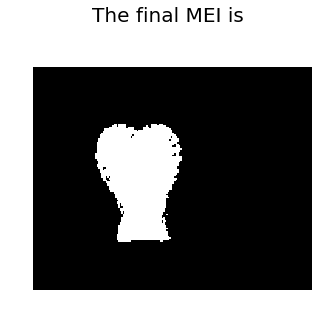

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.14968176056268073, 0.015888218362064464, 0.007170197109557259, 0.0007591290512055127, 0.05916068425401389, -0.008673099603856628, -0.001961053001987304]
Similitude moments for normalized MEI is:
 [0.13994146192199985, 0.017512791856781673, 0.008000918367473658, 0.0011895319454974828, 0.05562586129633696, -0.006605389395435629, -0.001421264917916939]


In [19]:
frame_grabber('denis_jack')
denis_jack = read_files('denis_jack')
denis_jack_bs = background_subtraction(denis_jack,denis_bg[0],20)
denis_jack_mhi = MHI(denis_jack_bs,20)
denis_jack_mei = MEI(denis_jack_bs)

denis_jack_mhi_n, denis_jack_mei_n = normalize(denis_jack_mhi, denis_jack_mei)
denis_jack_mhi_sm = similitude_moments(denis_jack_mhi_n)
denis_jack_mei_sm = similitude_moments(denis_jack_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_jack_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_jack_mei_sm)
denis_jack_sm = denis_jack_mhi_sm + denis_jack_mei_sm

# One hand wave

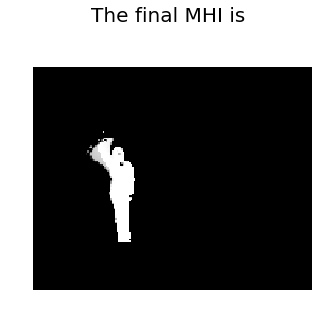

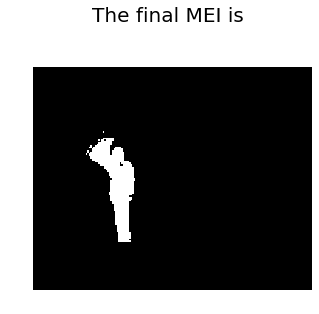

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.36549754993556355, 0.08214897718266255, 0.06864485096265475, -0.008135206794368162, 0.04357430510190917, -0.01383989789199882, -0.0064004199311387105]
Similitude moments for normalized MEI is:
 [0.34748059250727786, 0.08478648548275894, 0.07221932434028636, -0.0046219990312927044, 0.04747281291240165, -0.013540136432670427, -0.0072719253553640015]


In [20]:
frame_grabber('daria_wave1')
daria_wave1 = read_files('daria_wave1')
daria_wave1_bs = background_subtraction(daria_wave1,daria_bg[0],40)
daria_wave1_mhi = MHI(daria_wave1_bs,83)
daria_wave1_mei = MEI(daria_wave1_bs)

daria_wave1_mhi_n, daria_wave1_mei_n = normalize(daria_wave1_mhi, daria_wave1_mei)
daria_wave1_mhi_sm = similitude_moments(daria_wave1_mhi_n)
daria_wave1_mei_sm = similitude_moments(daria_wave1_mei_n)
print('Similitude moments for normalized MHI is:\n', daria_wave1_mhi_sm)
print('Similitude moments for normalized MEI is:\n', daria_wave1_mei_sm)
daria_wave1_sm = daria_wave1_mhi_sm + daria_wave1_mei_sm

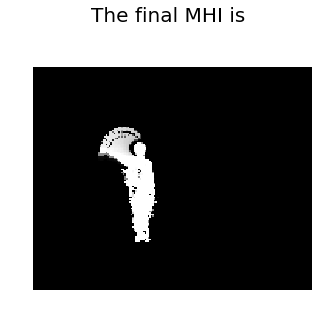

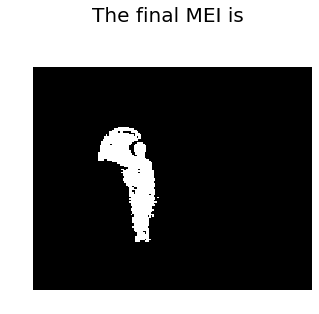

Maximum value in MHI:  1.0
Minimum value in MHI:  0.0
Maximum value in MEI:  1.0
Minimum value in MEI:  0.0
Similitude moments for normalized MHI is:
 [0.3237988568382455, 0.05579635508032173, 0.08186035411669203, -0.00656087674876705, 0.05819259004860015, -0.014592587149205027, -0.010270767699637945]
Similitude moments for normalized MEI is:
 [0.28701472421786756, 0.06156036064390049, 0.07732852186511803, 0.0029617196481389677, 0.059266999067213895, -0.00975436149075971, -0.008957481932893495]


In [21]:
frame_grabber('denis_wave1')
denis_wave1 = read_files('denis_wave1')
denis_wave1_bs = background_subtraction(denis_wave1,denis_bg[0],30)
denis_wave1_mhi = MHI(denis_wave1_bs,83)
denis_wave1_mei = MEI(denis_wave1_bs)

denis_wave1_mhi_n, denis_wave1_mei_n = normalize(denis_wave1_mhi, denis_wave1_mei)
denis_wave1_mhi_sm = similitude_moments(denis_wave1_mhi_n)
denis_wave1_mei_sm = similitude_moments(denis_wave1_mei_n)
print('Similitude moments for normalized MHI is:\n', denis_wave1_mhi_sm)
print('Similitude moments for normalized MEI is:\n', denis_wave1_mei_sm)
denis_wave1_sm = denis_wave1_mhi_sm + denis_wave1_mei_sm